<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Use_Cases/blob/main/Soccer_Ball_Recognition_and_Verification/Soccer_Ball_Recognition_and_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='A'></a>
# A - Face Recognition

Time to build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) and [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

In this exercise, we will:

* Implement one-shot learning to solve a face recognition problem
* Apply the triplet loss function to learn a network's parameters in the context of face recognition
* Explain how to pose face recognition as a binary classification problem
* Map face images into 128-dimensional encodings using a pretrained model
* Perform face verification and face recognition with these encodings

**Channels-last notation**

We'll be using a pre-trained model which represents ConvNet activations using a "channels last" convention. In other words, a batch of images will be of shape $(m, n_H, n_W, n_C)$. 

<a name='A.1'></a>
## A.1 - Packages & Setup

Go ahead and run the cell below to import the packages you'll need.

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

import os
import numpy as np
import pandas as pd
from numpy import genfromtxt
import pandas as pd

import PIL
import shutil
from zipfile import ZipFile

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [ ]:
install_package('wget')
import wget

install_package('ipdb')
import ipdb
#%pdb on

install_package('gdown')
import gdown

Installing wget ...
Package wget has been successfully installed
Reloading Packages
Installing ipdb ...
Package ipdb has been successfully installed
Reloading Packages
Package: gdown is already installed. Skipping installation
Reloading Packages


<a name = A.2></a>
## A.2 - Data Preparation

In [ ]:
def retrieve_data(data_instructions):
  for data_instruction in data_instructions:
    base_path, file, base_url, method, remove = data_instruction

    if os.path.isdir(base_path) and remove and (base_path != '.'):
      print(f'Removing directory tree: {base_path} ...')
      shutil.rmtree(base_path)

    if not os.path.isdir(base_path):
      print(f'Creating directory: {base_path} ...')
      os.mkdir(base_path)

    if not file == None:
      file_path = os.path.join(base_path, file)

      if os.path.isfile(file_path):
        if not remove:
          print(f'{file_path} already exists, skipping retrieve ...')
        else:
          print(f'Removing file: {file_path} ...')
          os.remove(file_path)
      else:
        if method == 'GDrive':
          print(f'Fetching from Google Drive: {file} ...')
          os.system(f'! gdown {base_url}') 
          os.replace(os.path.join('.', file), file_path)

        elif method == 'Github':
          print(f"Fetching from GitHub: {file} ...")
          url_path  = os.path.join(base_url, file)
          file_name = wget.download(url_path)
          os.replace(os.path.join('.', file), file_path)

      if file.lower().endswith('zip'):
        print(f"Extracting files in {file} ...")
        with ZipFile(file_path, 'r') as zippy:
          zippy.extractall(base_path)

[autoreload of IPython.core.debugger failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    del self.failed[py_filename]
ValueError: wrapper() requires a code object with 1 free vars, not 0
]


In [ ]:
data_instructions=list()
data_instructions.append(('./models', None, None, None, False))
data_instructions.append(('.', 'models.zip', 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/data/', 'Github', False))
data_instructions.append(('./models', 'keras-facenet_tf23.zip', '1TN3xJrE60Vfyi-DGmKT9RgB3FVAysYgi', 'GDrive', False))
data_instructions.append(('./models', 'keras-facenet-h5.zip', '1TTj3O3l_QHEjweQKdMdYSxYqK2W_vURD', 'GDrive', False))
data_instructions.append(('./images', None, None, None, True))
data_instructions.append(('.', 'images.zip', 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/data/', 'Github', False))
data_instructions.append(('.', 'Soccer_Balls.zip', 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/data/', 'Github', False))
retrieve_data(data_instructions)

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

Creating directory: ./models ...
Fetching from GitHub: models.zip ...
Extracting files in models.zip ...
Fetching from Google Drive: keras-facenet_tf23.zip ...
Extracting files in keras-facenet_tf23.zip ...
Fetching from Google Drive: keras-facenet-h5.zip ...
Extracting files in keras-facenet-h5.zip ...
Creating directory: ./images ...
Fetching from GitHub: images.zip ...
Extracting files in images.zip ...
Fetching from GitHub: Soccer_Balls.zip ...
Extracting files in Soccer_Balls.zip ...
Removing default sample_data directory...


<a name='A.3'></a>
## A.3 - Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/pixel_comparison.png" style="width:380px;height:150px;">
  <figcaption><center> <u> <font color='purple'> <b>Figure 1</b> </u></center></figcaption>
</figure>

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

<a name='A.4'></a>
## A.4 - Encoding Face Images into a 128-Dimensional Vector

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, you'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) 

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('./models/keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/keras-facenet-h5/model.h5')

Now summarize the input and output shapes: 

In [ ]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/distance_kiank.png" style="width:380px;height:150px;">
  <figcaption><center> <u> <font color='purple'> <b>Figure 2:</b> <br> </u> By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></figcaption>
</figure>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/triplet_comparison.png" style="width:380px;height:150px;">
  <figcaption><center> <u> <font color='purple'> <b>Figure 3:</b> Anchor (A), Positive (P), Negative (N) </u> </center></figcaption>
</figure>


<a name='A.5'></a>
## A.5 - The Triplet Loss

**Important Note**: Since we're using a pretrained model, we won't actually need to implement the triplet loss function in this assignment. *However*, the triplet loss is the main ingredient of the face recognition algorithm, and you'll need to know how to use it for training your own FaceNet model, as well as other types of image similarity problems. Therefore, you'll implement it below, for fun and edification. :) 

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/f_x.png" style="width:380px;height:150px;">
  <figcaption><center> <u> <font color='purple'> <b>Figure 4:</b> The triplet loss) </u> </center></figcaption>
</figure>

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. You'll use $\alpha = 0.2$.

Most implementations also rescale the encoding vectors to haven L2 norm equal to one (i.e., $\mid \mid f(img)\mid \mid_2$=1).




In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)

    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)

    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

<a name='A.6'></a>
## A.6 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

In [ ]:
FRmodel = model

Here are some examples of distances between the encodings between three individuals:

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/distance_matrix.png" style="width:380px;height:150px;">
  <figcaption><center> <u> <font color='purple'> <b>Figure 5:</b> Example of distance outputs between three individuals' encodings) </u> </center></figcaption>
</figure>

Now use this model to perform face verification and face recognition!

<a name='A.7'></a>
## A.7 - Applying the Model

You're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

You'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.



<a name='A.7.1'></a>
### A.7.1 - Face Verification

Now you'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, you'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

Run the following code to build the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [ ]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [ ]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the images of Danielle and Kian: 

In [ ]:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))

In [ ]:
type(danielle)

PIL.Image.Image

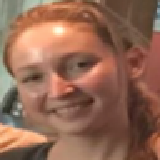

In [ ]:
danielle

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [ ]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)

    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity], ord=2)

    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
      
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run your verification algorithm on this picture:

<figure align="left">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/camera_0.jpg" style="width:180px;height:150px;">
</figure>

In [ ]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome in!


(0.59929454, True)

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg). 

<figure align="left">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Face_Recognition_and_Verification/notebook_images/camera_2.jpg" style="width:180px;height:150px;">
</figure>

Run the verification algorithm to check if Benoit can enter.

In [ ]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(1.0259346, False)

<a name='A.7.2'></a>
### A.7.2 - Face Recognition

Our face verification system is mostly working. But since Kian got his ID card stolen, when he came back to the office the next day he couldn't get in!

To solve this, we'd like to change your face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them!

We'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, you will no longer get a person's name as one of the inputs.

In [ ]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """

    encoding =  img_to_encoding(image_path, model)
    
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():

        dist = np.linalg.norm(encoding-db_enc, ord=2)

        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your `who_it_is()` algorithm identifies Younes.

In [ ]:
person_1 = tf.keras.preprocessing.image.load_img("images/camera_0.jpg", target_size=(160, 160))

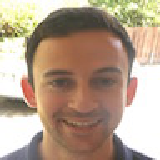

In [ ]:
person_1

In [ ]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.59929454


(0.59929454, 'younes')

In [ ]:
person_2 = tf.keras.preprocessing.image.load_img("images/younes.jpg", target_size=(160, 160))

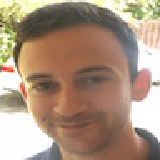

In [ ]:
person_2

In [ ]:
who_is_it("images/younes.jpg", database, FRmodel)

it's younes, the distance is 0.0


(0.0, 'younes')

<font color='blue'>
    
**What you should remember**:

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem.
    
- Triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
    
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person.

**Ways to improve your facial recognition model**:

Although you won't implement these here, here are some ways to further improve the algorithm:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.

# B - Use Case 1 - Soccer Ball recognition

Well, I agree that face recognition is important. The ability to recognize people, grant them access to places and all that is cool. But there are much cooler and important things than that!

Let's see how this architecture works for soccer balls! For this I grabbed pictures from FIFA's World Champeonship from 1930 till today. Let's create a new dataset and see how well it performs :-)

In [ ]:
_BALLS_DIR = './Soccer Balls'

files = os.listdir(_BALLS_DIR)

data = list()
for file in files:
  full_path = os.path.join(_BALLS_DIR, file)
  year = file[0:4]
  model = file[5:-4]
  encoding = img_to_encoding(full_path, FRmodel)
  data.append((year, model, file, full_path, encoding))


balls_df = pd.DataFrame(data=data, columns=['Year', 'Model', 'File Name', 'Full Path', '128-Encoding'])

In [ ]:
balls_df

,Year,Model,File Name,Full Path,128-Encoding
0,1950,Duplo T,1950-Duplo T.png,./Soccer Balls/1950-Duplo T.png,"[[-0.07653792, -0.0294848, -0.033840016, -0.09..."
1,1974,Telstar Durlast,1974-Telstar Durlast.png,./Soccer Balls/1974-Telstar Durlast.png,"[[-0.046695665, -0.07283041, -0.047206175, -0...."
2,2014,Brazuca Final Rio,2014-Brazuca Final Rio.png,./Soccer Balls/2014-Brazuca Final Rio.png,"[[-0.067823276, -0.09556091, -0.00061318907, -..."
3,1954,Swiss World Champion,1954-Swiss World Champion.png,./Soccer Balls/1954-Swiss World Champion.png,"[[0.013744663, -0.021612369, -0.009602376, -0...."
4,1938,Allen,1938-Allen.png,./Soccer Balls/1938-Allen.png,"[[-0.053419635, -0.07942785, -0.045183208, -0...."
5,1930,T-Model,1930-T-Model.png,./Soccer Balls/1930-T-Model.png,"[[0.012457879, -0.06328766, -0.049208127, -0.1..."
6,2022,Al Rihla,2022-Al Rihla.png,./Soccer Balls/2022-Al Rihla.png,"[[-0.04718596, -0.076978855, -0.047718138, -0...."
7,1998,Ticolore,1998-Ticolore.png,./Soccer Balls/1998-Ticolore.png,"[[-0.044506587, -0.105916, 0.008054997, -0.097..."
8,2010,Jobulani,2010-Jobulani.png,./Soccer Balls/2010-Jobulani.png,"[[-0.038832355, -0.10838953, -0.124639645, -0...."
9,1958,Top Star,1958-Top Star.png,./Soccer Balls/1958-Top Star.png,"[[-0.027239399, -0.0943997, -0.06764144, -0.15..."


Notice the encoding is the 5th column.

Now, let's redefine the adfs function to work nicely on dataframes (I just love them)

In [ ]:
def what_ball_is_it(encoding, balls_df):
  """
  Implements BALL RECOGNITION to tell you what World Cup is being played.
  
  Arguments:
      encoding
      ball_df
  
  Returns:
      min_dist -- the minimum distance between image_path encoding and the encodings from the database
      identity -- string, the name prediction for the person on image_path
  """
  N_balls = balls_df.shape[0]

  res = [0] * N_balls
  for i in range(N_balls):
     res[i] = np.linalg.norm(balls_df['128-Encoding'][i] - encoding, ord=2)
  balls_df['L2 Distance'] = res                  

  cand_id = balls_df['L2 Distance'].idxmin()
      
  return cand_id

Selected ball - 	Model: Telstar 18 Mechta - Year: 2018


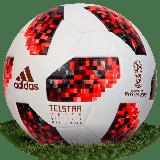

Recognized ball - 	Model: Telstar 18 Mechta - Year: 2018


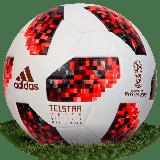




Selected ball - 	Model: Jobulani - Year: 2010


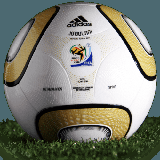

Recognized ball - 	Model: Jobulani - Year: 2010


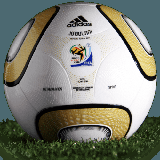




Selected ball - 	Model: Al Rihla - Year: 2022


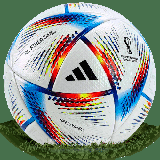

Recognized ball - 	Model: Al Rihla - Year: 2022


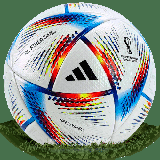




Selected ball - 	Model: Telstar Durlast - Year: 1974


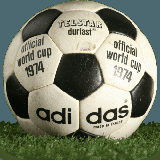

Recognized ball - 	Model: Telstar Durlast - Year: 1974


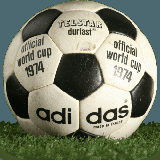




Selected ball - 	Model: Brazuca Final Rio - Year: 2014


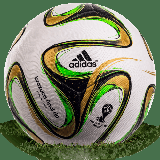

Recognized ball - 	Model: Brazuca Final Rio - Year: 2014


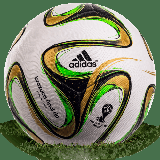




Selected ball - 	Model: Crack Top Star - Year: 1962


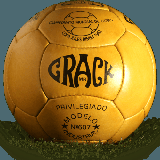

Recognized ball - 	Model: Crack Top Star - Year: 1962


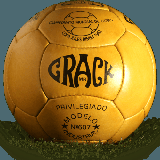




Selected ball - 	Model: Azteca - Year: 1986


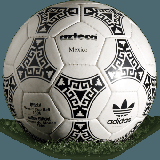

Recognized ball - 	Model: Azteca - Year: 1986


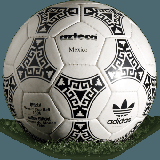




Selected ball - 	Model: Questra - Year: 1994


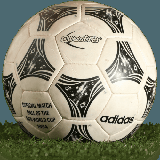

Recognized ball - 	Model: Questra - Year: 1994


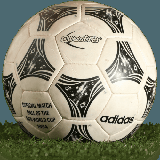




Selected ball - 	Model: Allen - Year: 1938


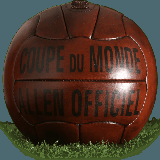

Recognized ball - 	Model: Allen - Year: 1938


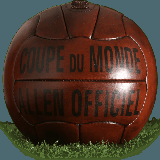




Selected ball - 	Model: Teamgeist - Year: 2006


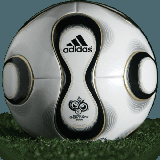

Recognized ball - 	Model: Teamgeist - Year: 2006


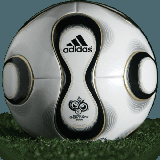

In [ ]:
# Testing the recognition capabilities on World-Cup Soccer Balls
for i in range(10):
  sel = np.random.randint(0, balls_df.shape[0])
  print(f"Selected ball - \tModel: {balls_df['Model'][sel]} - Year: {balls_df['Year'][sel]}")
  sel_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][sel], target_size=(160, 160))
  display(sel_image)

  encoding = img_to_encoding(balls_df['Full Path'][sel], FRmodel)
  rec = what_ball_is_it(encoding, balls_df)
  print(f"Recognized ball - \tModel: {balls_df['Model'][rec]} - Year: {balls_df['Year'][rec]}")
  rec_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][rec], target_size=(160, 160))
  display(rec_image)
  print('\n\n')

Well, now we can really agree we implemented an useful solution for a valuable and usable application. But wait... what if the balls are rotated? Let's give it a try.

Selected ball - 	Model: T-Model - Year: 1930 - Rotation = 227 degrees


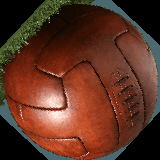

Recognized ball - 	Model: T-Model - Year: 1930


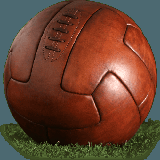




Selected ball - 	Model: Challenge 4-star - Year: 1966 - Rotation = 218 degrees


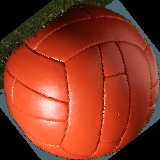

Recognized ball - 	Model: Challenge 4-star - Year: 1966


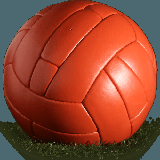




Selected ball - 	Model: Duplo T - Year: 1950 - Rotation = 125 degrees


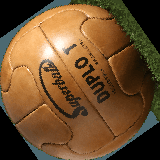

Recognized ball - 	Model: Duplo T - Year: 1950


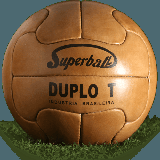




Selected ball - 	Model: Brazuca Final Rio - Year: 2014 - Rotation = 66 degrees


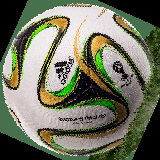

Recognized ball - 	Model: Brazuca Final Rio - Year: 2014


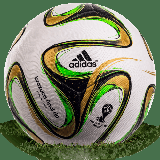




Selected ball - 	Model: Telstar 18 Mechta - Year: 2018 - Rotation = 268 degrees


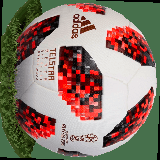

Recognized ball - 	Model: Telstar 18 Mechta - Year: 2018


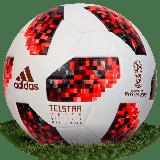




Selected ball - 	Model: Nike Ordem 4 - Year: 2018 - Rotation = 147 degrees


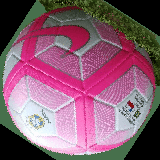

Recognized ball - 	Model: Nike Ordem 4 - Year: 2018


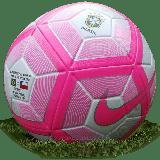




Selected ball - 	Model: Federale 102 - Year: 1934 - Rotation = 260 degrees


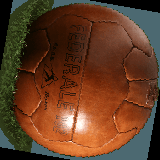

Recognized ball - 	Model: Federale 102 - Year: 1934


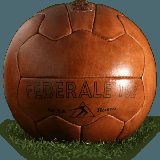




Selected ball - 	Model: Questra - Year: 1994 - Rotation = 19 degrees


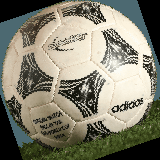

Recognized ball - 	Model: Questra - Year: 1994


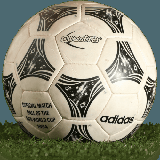




Selected ball - 	Model: Telstar 18 Mechta - Year: 2018 - Rotation = 328 degrees


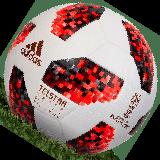

Recognized ball - 	Model: Telstar 18 Mechta - Year: 2018


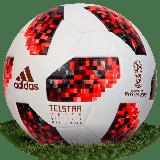




Selected ball - 	Model: Teamgeist Berlin - Year: 2006 - Rotation = 215 degrees


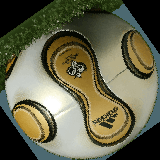

Recognized ball - 	Model: Teamgeist Berlin - Year: 2006


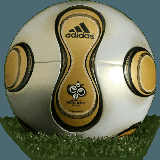

In [ ]:
# Testing the recognition capabilities on World-Cup Soccer Balls
for i in range(10):
  sel = np.random.randint(0, balls_df.shape[0])
  rotation = np.random.randint(10, 350)
  print(f"Selected ball - \tModel: {balls_df['Model'][sel]} - Year: {balls_df['Year'][sel]} - Rotation = {rotation} degrees")
  sel_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][sel], target_size=(160, 160))
  sel_image = sel_image.rotate(rotation, PIL.Image.NEAREST)
  display(sel_image)

  encoding = img_to_encoding(balls_df['Full Path'][sel], FRmodel)
  rec = what_ball_is_it(encoding, balls_df)
  print(f"Recognized ball - \tModel: {balls_df['Model'][rec]} - Year: {balls_df['Year'][rec]}")
  rec_image = tf.keras.preprocessing.image.load_img(balls_df['Full Path'][rec], target_size=(160, 160))
  display(rec_image)
  print('\n\n')

Now... I'm really really impressed :-)

Time to move to the next one...

<a name='C'></a>
# C - References
1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)

2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)

3. This implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet

4. Further inspiration was found here: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

5. And here: https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/tf_to_keras.ipynb